# DFM Mixture Models with PyStan
I've adapted Dan Foreman-Mackey's [excellent blog](http://dfm.io/posts/mixture-models/) on utilising marginalised mixture models ([Hogg et al. 2010](http://adsabs.harvard.edu/abs/2010arXiv1008.4686H)) using emcee to PyStan, achieving similar results. Please see both the above sources for the full underlying theory!

The main difference is in the treatment of the posterior probability calculation and the treatment of the parameter transformations in Stan.

All code in this notebook that does not directly relate to the use of PyStan was written by Dan Foreman-Mackey in his blog, and the credit is his, not mine.

Thanks to [G. R. Davies](https://github.com/grd349) and [J. S. Kuszlewicz](https://github.com/jsk389).
 
You can find me on: [Github](https://github.com/ojhall94]) | [Twitter](https://twitter.com/ojhall94) | ojhall94-at-gmail-dot-com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We'll choose the parameters of our synthetic data.
# The outlier probability will be 80%:
true_frac = 0.8

# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
x = np.sort(np.random.uniform(-2, 2, 15))
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

#Save the truth
truths = true_params + [true_frac, true_outliers[0], np.log(true_outliers[1])]

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
m_bkg = np.random.rand(len(x)) > true_frac
y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1]+yerr[m_bkg]**2) * np.random.randn(sum(m_bkg))

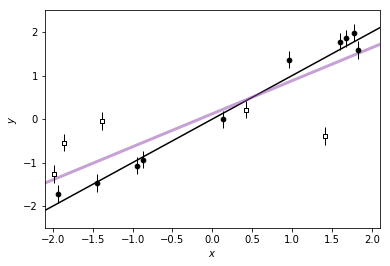

In [3]:
# First, fit the data and find the maximum likelihood model ignoring outliers.
A = np.vander(x, 2)
p = np.linalg.solve(np.dot(A.T, A / yerr[:, None]**2), np.dot(A.T, y / yerr**2))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)

# Plot the data and the truth.
plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w",edgecolor='k', zorder=1000)
plt.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000)
plt.plot(x0, y0, color="k", lw=1.5)

# Plot the best fit line.
plt.plot(x0, x0 * p[0] + p[1], color="#8d44ad", lw=3, alpha=0.5)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2.5, 2.5)
plt.xlim(-2.1, 2.1);

In [7]:
#Now we have to put this through PyStan
import pystan
code = '''
data {
    int<lower = 0> N;
    real x[N];
    real y[N];
    real err[N];
}
parameters {
    real m;
    real b;
    real<lower=0, upper=1> Q;
    real M;
    real lnV;
}
model {
    m ~ normal(1., 0.9);
    b ~ normal(0., 0.9);
    Q ~ normal(0.5,.5);
    M ~ normal(0., 2.4);
    lnV ~ normal(-1.,4.);
    
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(y[n] | m*x[n] + b, err[n]),
                    normal_lpdf(y[n] | M, sqrt(err[n]^2 + exp(lnV))));
}
generated quantities{
    vector[N] post_prob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(y[n] | m*x[n] + b, err[n]);
        ll_bg = log(1-Q) + normal_lpdf(y[n] | M, sqrt(err[n]^2 + exp(lnV)));
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        }
}
'''
sm = pystan.StanModel(model_code = code, model_name='dfmmm')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL dfmmm_25fa888852713a55bee3611e9b56623d NOW.


In [16]:
#Load in the data
dat = {'N': len(x),
      'x': x,
      'y': y,
      'err':yerr}
fit = sm.sampling(data=dat, iter=5000, chains=4)

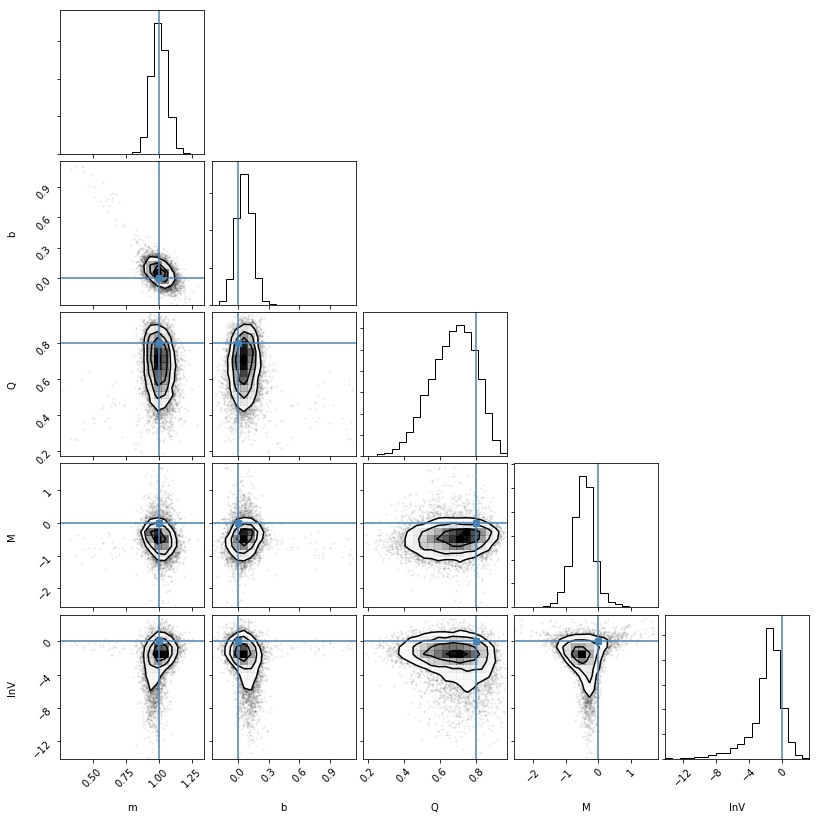

In [17]:
import corner
#Plot the resulting chains
trace = fit.extract()
chain = np.array([trace['m'],trace['b'],trace['Q'],trace['M'],trace['lnV']])
corner.corner(chain.T,\
             labels=['m','b','Q','M','lnV'],\
             truths=truths)
plt.show()

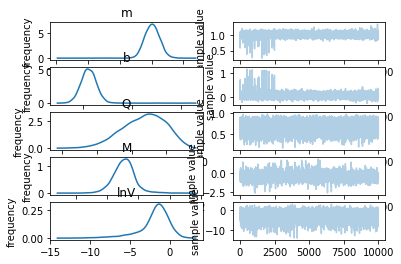

In [18]:
#Plot the chains in the Stan format
fit.plot(pars=['m','b','Q','M','lnV'])
plt.show()

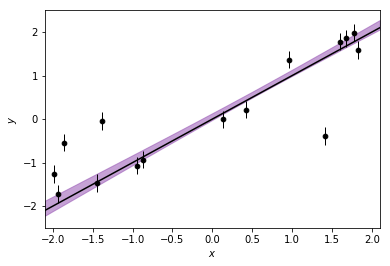

In [19]:
# Compute the quantiles of the predicted line and plot them.
A = np.vander(x0, 2)
lines = np.dot(chain.T[:,:2], A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
plt.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5)

# Plot the data.
plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x, y, marker="o", s=22, c="k", zorder=1000)

# Plot the true line.
plt.plot(x0, y0, color="k", lw=1.5)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2.5, 2.5)
plt.xlim(-2.1, 2.1);

In [20]:
#Now lets read out and normalize the posterior probability trace
pp = trace['post_prob'] #This contains the inlier probability for each data point for each step in the Stan chain
post_prob = np.sum(pp,axis=0)/pp.shape[0] #We add all the probabilities and normalise for the full set

In [21]:
print(", ".join(map("{0:.3f}".format, post_prob)))

0.312, 0.925, 0.001, 0.944, 0.002, 0.875, 0.871, 0.822, 0.845, 0.966, 0.000, 0.995, 0.995, 0.995, 0.977


(-2.1, 2.1)

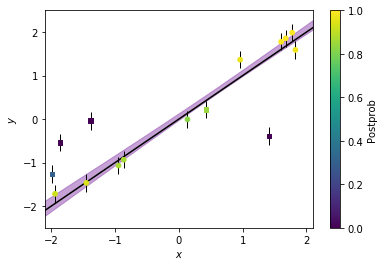

In [22]:
# Plot the predition.
plt.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5)

# Plot the data points.
plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
# Plot the (true) outliers.
c = plt.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c=post_prob[m_bkg], cmap="viridis", vmin=0, vmax=1, zorder=1000)
# Plot the (true) good points.
plt.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c=post_prob[~m_bkg], cmap="viridis", vmin=0, vmax=1, zorder=1000)

# Plot the true line.
plt.plot(x0, y0, color="k", lw=1.5)

#Add a colorbar
plt.colorbar(c, label='Postprob')

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2.5, 2.5)
plt.xlim(-2.1, 2.1)